In [17]:
import numpy as np
import time
import pandas as pd
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
from skmap.misc import find_files, GoogleSheet, ttprint
from model_fit import textures_fw_transform, textures_bw_transform
import json

folder_path = '/mnt/ripley/global_soc/scikit-map/global-soil-mapping'
# version = "20250204"
version = "20250523"
df = pd.read_parquet(f'{folder_path}/material/ovelayed_props_v{version}.pq')
print(df.shape)

(591362, 380)


## drop useless column 

In [18]:
df = df.drop(columns= ['Unnamed: 0','longitude_decimal_degrees', 'latitude_decimal_degrees'])
print(df.shape)

(591362, 377)


## rename columns to match the modeling pipeline

In [19]:
df = df.rename(columns = {'observation_year':'year', 'hzn_depth':'hzn_dep','ph_h2o':'ph.h2o', 'organic_carbon':'soc', 'oc_d.f':'ocd',
                          'bulk_density_oven_dry':'bulk.density', 'clay_total':'clay', 'silt_total':'silt', 'sand_total':'sand',
                          'total_frag_wt_pct_gt_2_mm_ws':'coarse'})
print(df.shape)

(591362, 377)


## stardardize the column data types

In [20]:
# mainly the string columns
str_col = ['olc_id', 'site_key', 'source_db']
for ii in str_col:
    df[ii] = df[ii].astype(str)
    
print(df.shape)

(591362, 377)


## prepare climatic region column

In [21]:
cz=[]
for ii in df.columns:
    if '_kg' in ii:
        if '2_' not in ii:
            cz.append(ii)
        
df = df.drop(columns=cz)
print(df.shape)

(591362, 372)


In [22]:
value_to_class_df = pd.read_csv(f'{folder_path}/material/kg2_lookup_table.csv')
value_to_class = dict(zip(value_to_class_df['number'].values.tolist(),value_to_class_df['class'].values.tolist()))

df = df.rename(columns={'CHELSA_kg2_1981-2010_V.2.1':'clm_code'})
df['clm_class'] = df['clm_code'].map(value_to_class)
print(df.shape)

(591362, 373)


## check the missing values for property data: the targets

In [23]:
prop_col = ['ph.h2o', 'soc', 'ocd', 'bulk.density', 'clay', 'silt', 'sand', 'coarse']

# check the validity of soil properties
for icol in prop_col:
    if df[icol].isna().sum()/len(df)>0.02:
        rto = round(df[icol].isna().sum()/len(df),2)
        print(df[icol].isna().sum(), icol, rto)
        
df = df.dropna(subset=prop_col, how='all')
print('\ndata size after dropping nan prop, ', df.shape)

319003 ph.h2o 0.54
183097 soc 0.31
375426 ocd 0.63
453970 bulk.density 0.77
228103 clay 0.39
227749 silt 0.39
228474 sand 0.39
376897 coarse 0.64

data size after dropping nan prop,  (577766, 373)


## check the missing values for feature data: the covariates

In [24]:
# get the covariate column
meta_col = ['year', 'hzn_dep', 'hzn_top', 'hzn_bot','lat','lon','clm_class','clm_code']

cov_col = []
for ii in df.columns:
    if ii not in meta_col:
        if ii not in prop_col:
            if ii not in str_col:
                cov_col.append(ii)
                
print('check column number:', len(meta_col)+len(cov_col)+len(prop_col)+len(str_col))

check column number: 373


In [25]:
# then check invalid values for each covariate
drop_col = []

for icol in cov_col:
    if df[icol].isna().sum()/len(df)>0.03:
        rto = round(df[icol].isna().sum()/len(df),2)
        print(df[icol].isna().sum(), rto, icol)
        drop_col.append(icol)
        
# drop covariates with invalid values more than 2%
df = df.drop(columns = drop_col)
cov_col = [ii for ii in cov_col if ii not in drop_col]
print(f'drop {len(drop_col)} columns with > 3% nan')
print('\ndata size after dropping nan cov columns, ', df.shape)

30652 0.05 bare.soil_mcd43a4.fc_std_500m_s_YYYY0101_YYYY1231_go_epsg.4326_v20240616
26705 0.05 photosynthetic.veg_mcd43a4.fc_mx_500m_s_YYYY0101_YYYY1231_go_epsg.4326_v20240616
18257 0.03 bare.soil_mcd43a4.fc_m_500m_s_YYYY0101_YYYY1231_go_epsg.4326_v20240616
31041 0.05 non.photosynthetic.veg_mcd43a4.fc_m_500m_s_YYYY0101_YYYY1231_go_epsg.4326_v20240616
29244 0.05 photosynthetic.veg_mcd43a4.fc_m_500m_s_YYYY0101_YYYY1231_go_epsg.4326_v20240616
29091 0.05 non.photosynthetic.veg_mcd43a4.fc_mx_500m_s_YYYY0101_YYYY1231_go_epsg.4326_v20240616
27614 0.05 photosynthetic.veg_mcd43a4.fc_std_500m_s_YYYY0101_YYYY1231_go_epsg.4326_v20240616
17789 0.03 bare.soil_mcd43a4.fc_mx_500m_s_YYYY0101_YYYY1231_go_epsg.4326_v20240616
22948 0.04 CHELSA_gdd10_1981-2010_V.2.1
369872 0.64 CHELSA_swe_1981-2010_V.2.1
23301 0.04 CHELSA_gsp_1981-2010_V.2.1
23301 0.04 CHELSA_gst_1981-2010_V.2.1
drop 12 columns with > 3% nan

data size after dropping nan cov columns,  (577766, 361)


## only keep landsat annual band p25

In [26]:
landsat_bimonthly_col = []
for ii in cov_col:
    if 'glad.swa.ard2' in ii:
        print(ii)
        if 'p25' not in ii:
            landsat_bimonthly_col.append(ii)

cov_col = [ii for ii in cov_col if ii not in landsat_bimonthly_col]
with open(f'{folder_path}/material/soil_cov_no.bimonthly.landsat_v{version}.json', "w") as file:
    json.dump(cov_col, file)
    
print(len(cov_col))

red_glad.swa.ard2_m_30m_s_YYYY0701_YYYY0831_go_epsg.4326_v1
swir2_glad.swa.ard2_m_30m_s_YYYY0701_YYYY0831_go_epsg.4326_v1
swir1_glad.swa.ard2_m_30m_s_YYYY0701_YYYY0831_go_epsg.4326_v1
savi_glad.swa.ard2_m_30m_s_YYYY0301_YYYY0430_go_epsg.4326_v1
ndti_glad.swa.ard2_p25_30m_s_YYYY0101_YYYY1231_go_epsg.4326_v1
ndsi_glad.swa.ard2_m_30m_s_YYYY0701_YYYY0831_go_epsg.4326_v1
blue_glad.swa.ard2_m_30m_s_YYYY1101_YYYY1231_go_epsg.4326_v1
ndwi_glad.swa.ard2_p25_30m_s_YYYY0101_YYYY1231_go_epsg.4326_v1
ndvi_glad.swa.ard2_m_30m_s_YYYY0501_YYYY0630_go_epsg.4326_v1
green_glad.swa.ard2_m_30m_s_YYYY0301_YYYY0430_go_epsg.4326_v1
blue_glad.swa.ard2_m_30m_s_YYYY0901_YYYY1031_go_epsg.4326_v1
ndvi_glad.swa.ard2_m_30m_s_YYYY0901_YYYY1031_go_epsg.4326_v1
swir2_glad.swa.ard2_m_30m_s_YYYY0901_YYYY1031_go_epsg.4326_v1
swir2_glad.swa.ard2_m_30m_s_YYYY1101_YYYY1231_go_epsg.4326_v1
blue_glad.swa.ard2_m_30m_s_YYYY0701_YYYY0831_go_epsg.4326_v1
red_glad.swa.ard2_m_30m_s_YYYY0901_YYYY1031_go_epsg.4326_v1
ndwi_glad.swa.ard

## organize texture data

In [27]:
# Calculate the 2 components O1 and O2

sand = df['sand'].to_numpy()
silt = df['silt'].to_numpy()
clay = df['clay'].to_numpy()

texture_1, texture_2 = textures_fw_transform(sand, silt, clay)

sand_bw, silt_bw, clay_bw = textures_bw_transform(texture_1, texture_2)
print(np.nanmean(sand_bw-sand))
print(np.nanmean(silt_bw-silt))
print(np.nanmean(clay_bw-clay))

df['texture1'] = texture_1
df['texture2'] = texture_2

print('data size after adding 2 texture component, ', df.shape)

-0.0005205241243068865
-0.0004895849133119629
-0.0005867294284761566
data size after adding 2 texture component,  (577766, 363)


## assign depth bin for later examination

In [28]:
bins = [0, 30, 60, 100, float('inf')]
labels = ['0-30', '30-60', '60-100', '>100']  
df['hzn_dep_bin'] = pd.cut(df['hzn_dep'], bins=bins, labels=labels, right=True)
print(df.shape)

(577766, 364)


## assign tile id

In [29]:
tiles = gpd.read_file(f'{folder_path}/material/tiles_GH_100km_land.gpkg')
tiles = tiles.rename(columns={'ID':'tile_id'})
tiles = tiles.to_crs('EPSG:4326')
tiles = tiles[['tile_id','geometry']]

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
gdf.crs = 'EPSG:4326'
gdf = gdf.to_crs(tiles.crs)

# join spatial
joined_gdf = gpd.sjoin(gdf, tiles, how="left", op='within')
joined_gdf = joined_gdf.drop(columns=['geometry','index_right'])

# fill none values
joined_gdf['tile_id'] = joined_gdf['tile_id'].fillna('unknown')

print('data size with tile id', joined_gdf.shape)
joined_gdf.to_parquet(f'{folder_path}/material/soil_pnts_organized_v{version}.pq')

data size with tile id (577766, 365)


## plot data availibility

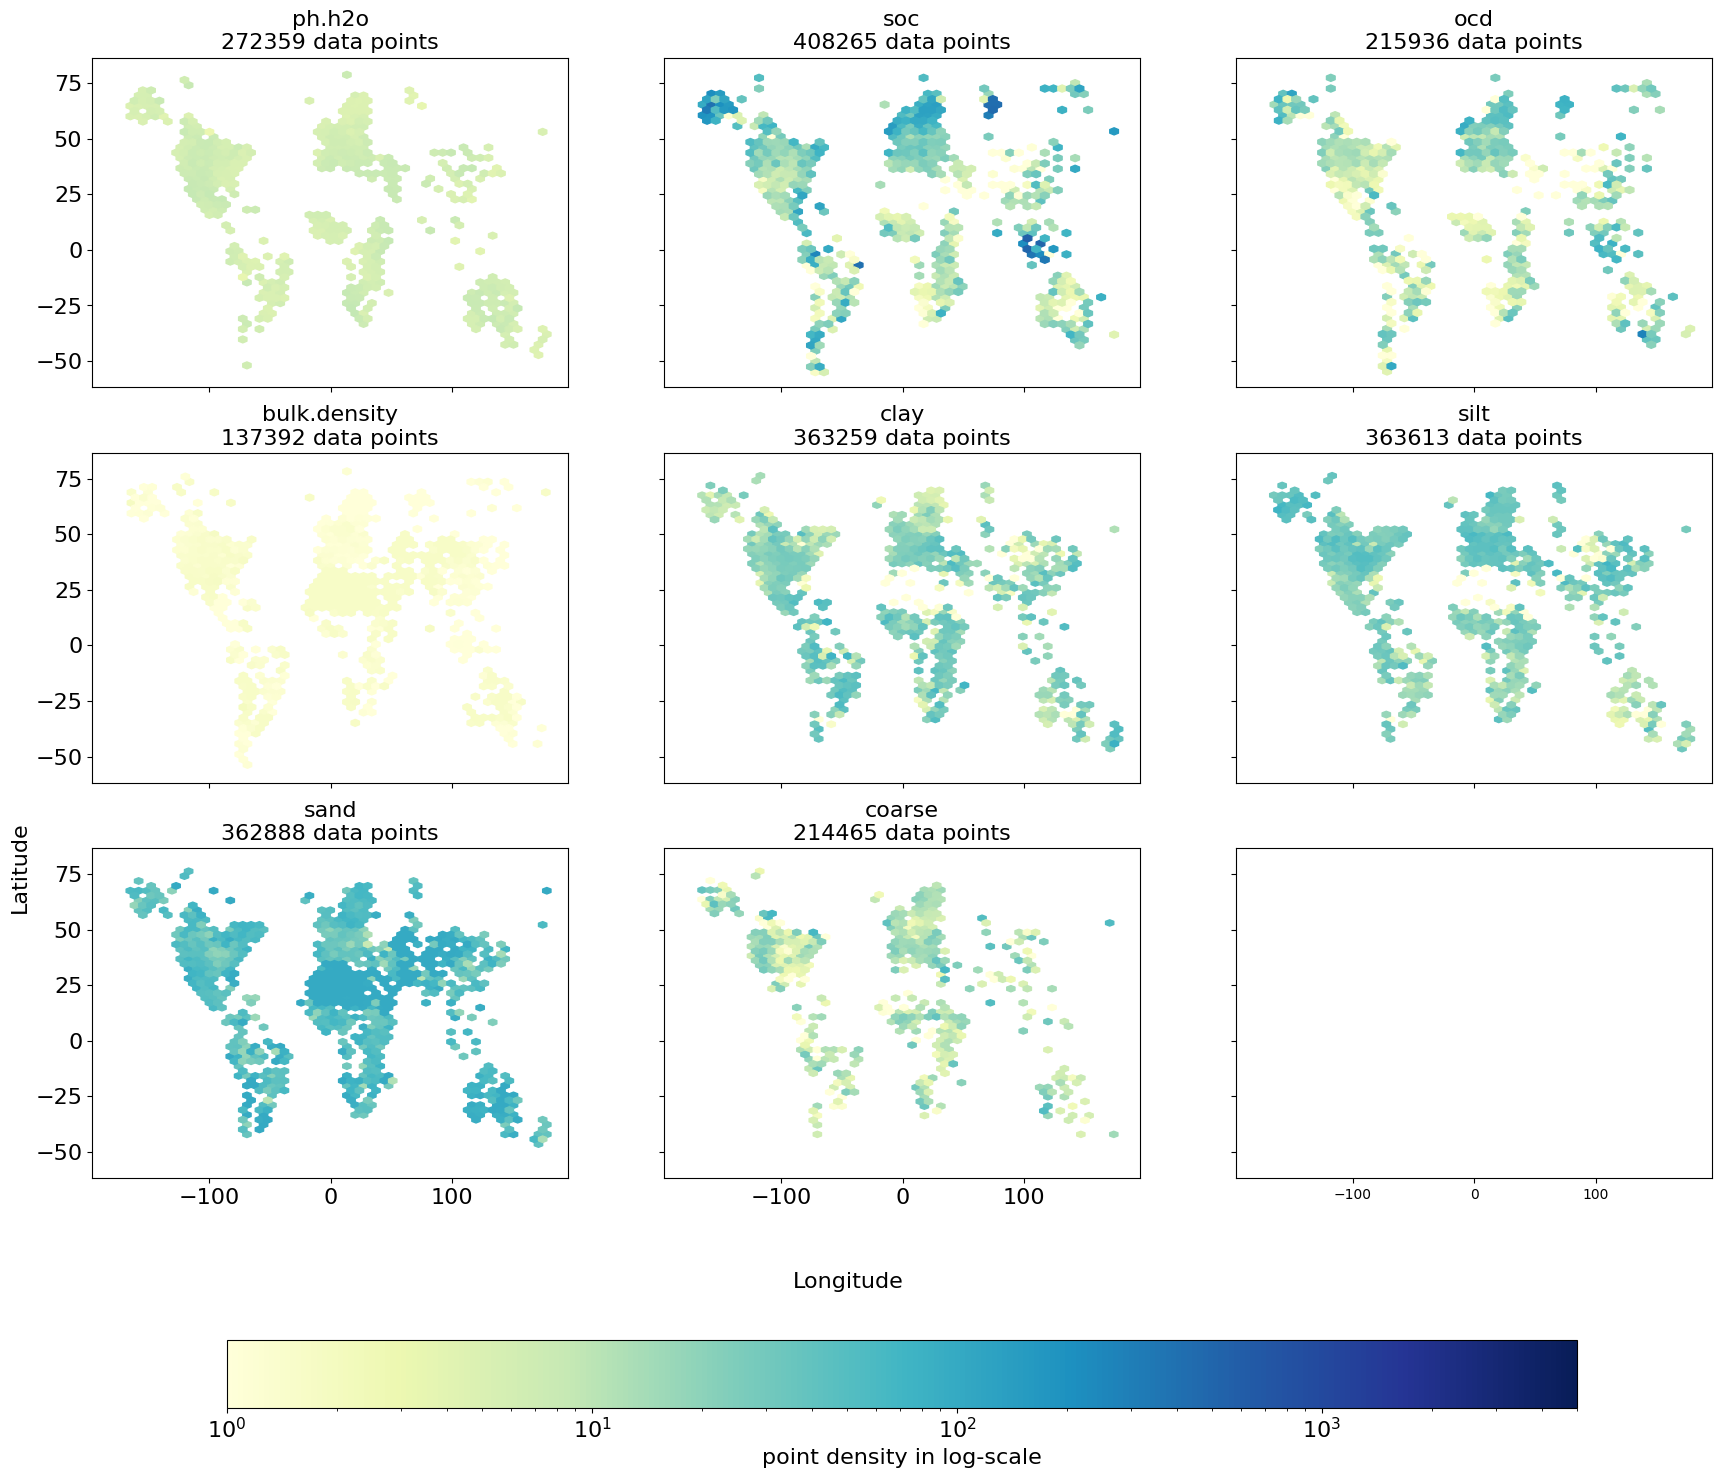

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

dff = pd.read_parquet(f'{folder_path}/material/soil_pnts_organized_v{version}.pq')

# Columns for which you want to create spatial hexbin plots
columns_to_plot = prop_col

# Set the global minimum and maximum values for the color scale
vmin = 1
vmax = 5000

# Create subplots (2 rows and 3 columns) for the 6 variables
fig, axes = plt.subplots(3, 3, figsize=(18, 18), sharex=True, sharey=True)

# Flatten the axes array to loop through easily
axes = axes.ravel()

# Define a common logarithmic color scale
norm = LogNorm(vmin=vmin, vmax=vmax)

# Loop over each column and plot the hexbin in a separate subplot
for i, col in enumerate(columns_to_plot):
    # Drop rows with missing values in the current column
    dff = df.dropna(subset=[col])

    # Plot hexbin with shared log scale for the color intensity
    hb = axes[i].hexbin(dff['lon'], dff['lat'], C=dff[col], gridsize=50, cmap='YlGnBu', 
                        norm=norm, reduce_C_function=np.mean)

    # Add title for each subplot with font size 16, including number of data points
    axes[i].set_title(f'{col}\n{len(dff)} data points', fontsize=16)

    # Set tick label sizes to 16
    axes[i].tick_params(axis='both', which='major', labelsize=16)

fig.text(0.5, 0.27, 'Longitude', ha='center', va='center', fontsize=16)  # Move x-label higher
fig.text(0.04, 0.5, 'Latitude', ha='center', va='center', rotation='vertical', fontsize=16)

# Adjust layout to reduce the margins between subplots and ensure x-label is above the colorbar
plt.subplots_adjust(left=0.08, bottom=0.2, right=0.98, top=0.95, wspace=0.2, hspace=0.2)

# Create a colorbar for the entire figure at the bottom (below the xlabel)
cbar = fig.colorbar(hb, ax=axes, orientation='horizontal', fraction=0.05, pad=0.12)
cbar.set_label('point density in log-scale', fontsize=16)
cbar.ax.tick_params(labelsize=16)

plt.savefig(f'{folder_path}/material/plot_all.prop_availibility_v{version}.png', bbox_inches='tight', dpi=300)

plt.show()


## plot availibity based on climatic region and depth interval

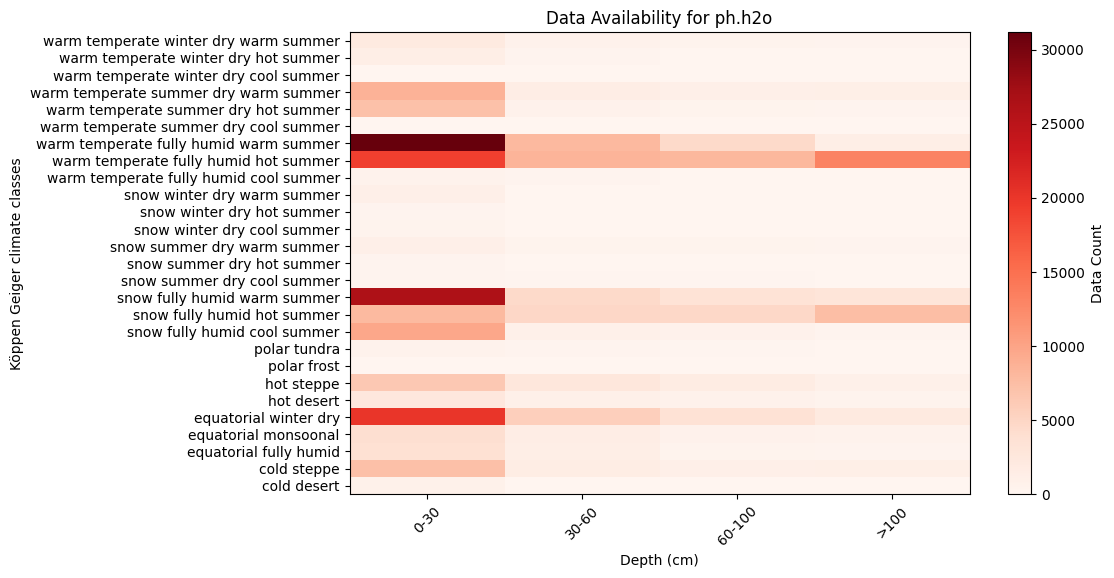

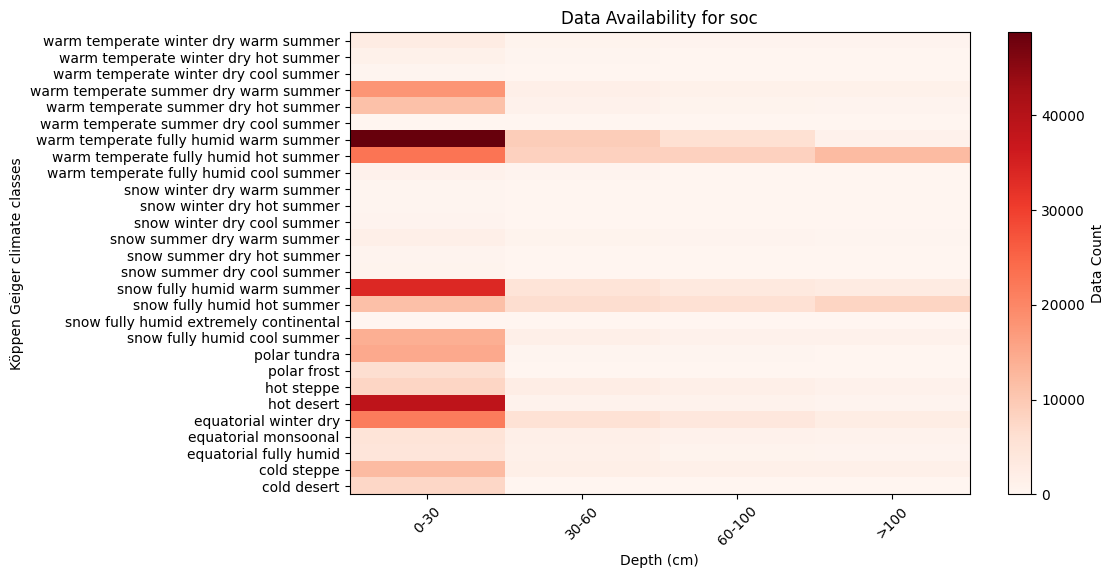

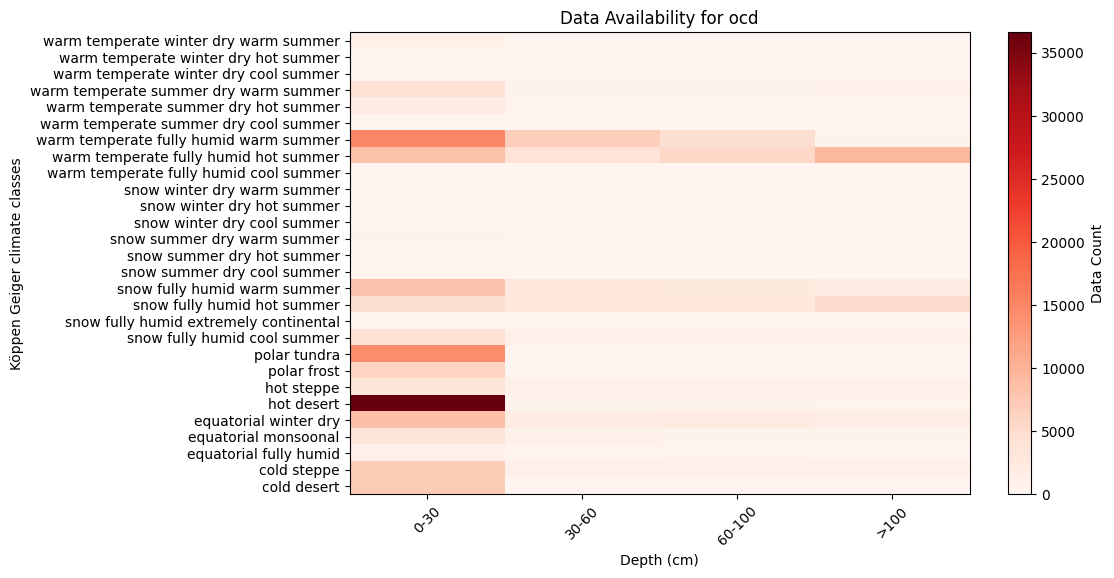

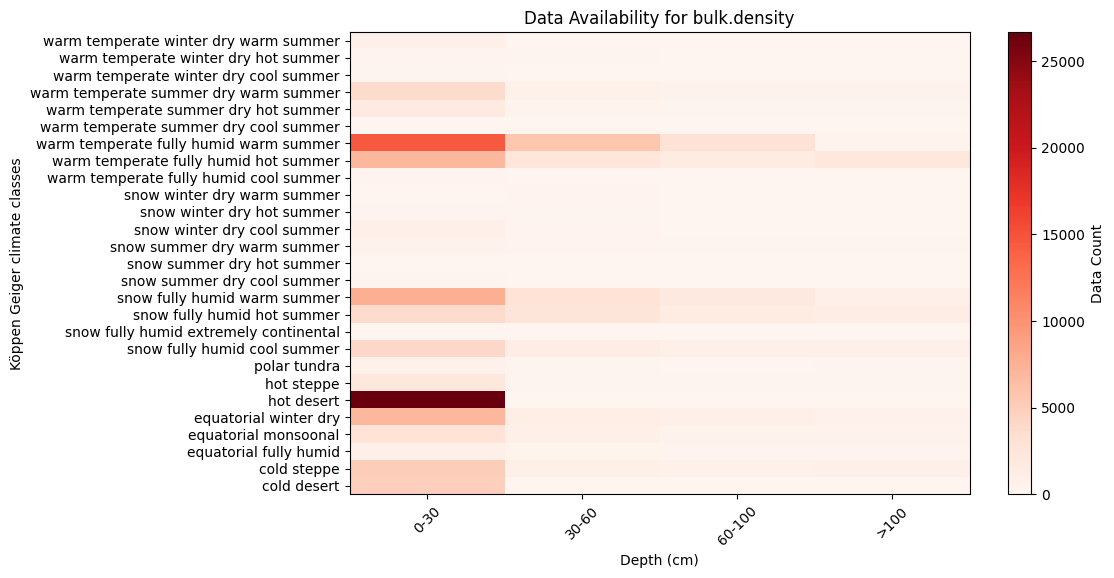

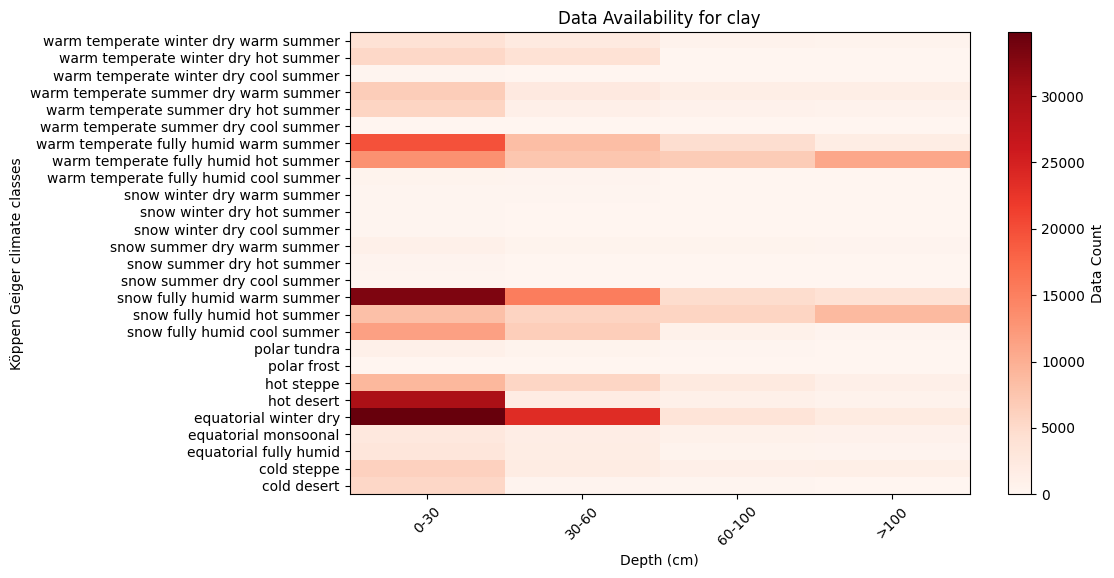

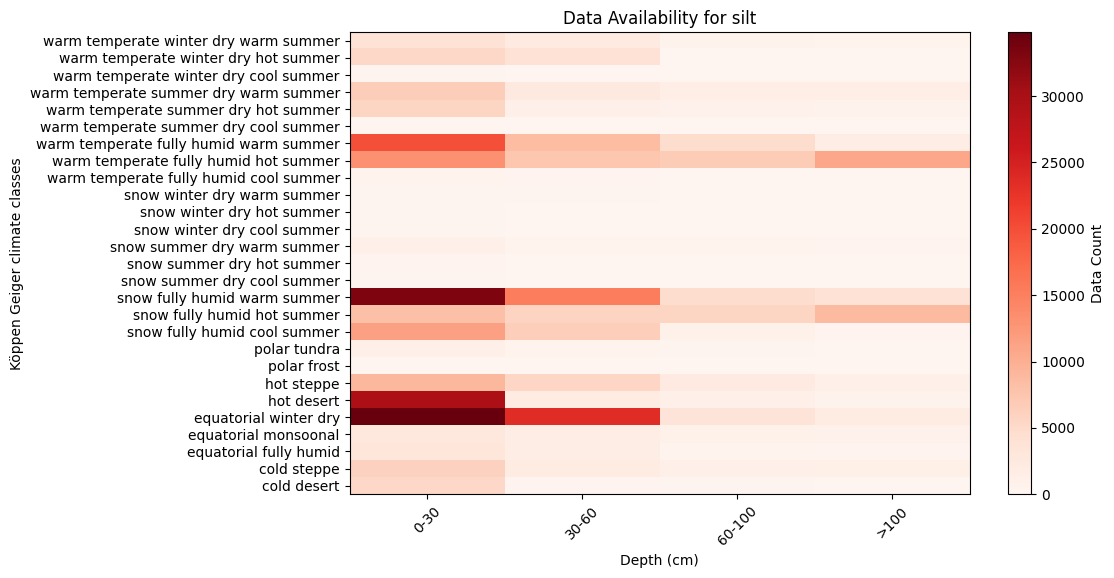

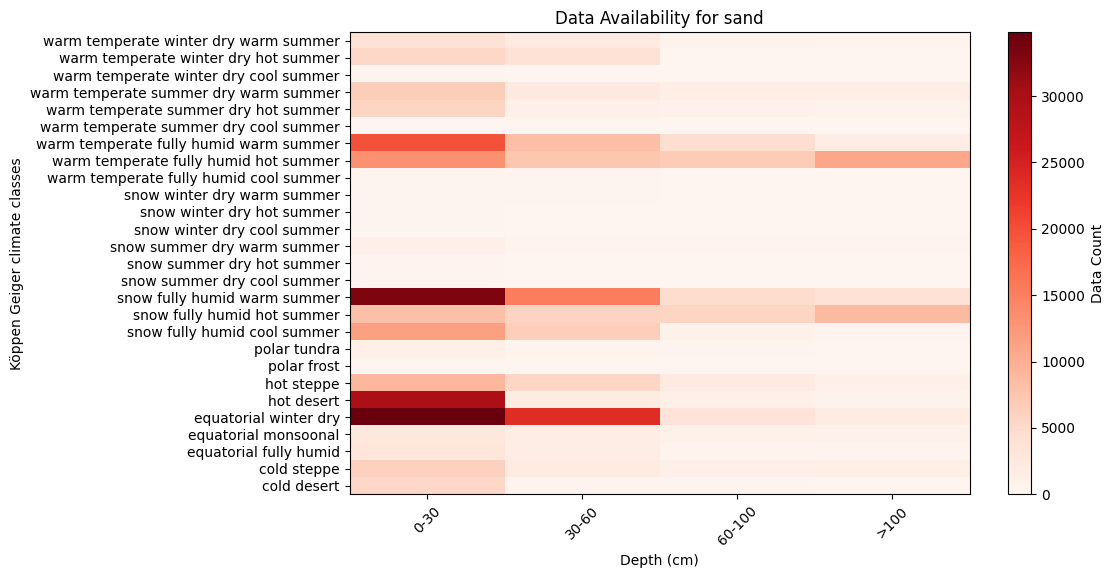

In [31]:
import matplotlib.pyplot as plt

for prop in prop_col[0:-1]:
    filtered_df = df[['clm_class', 'hzn_dep_bin', prop]].dropna()

    grouped = filtered_df.groupby(['clm_class', 'hzn_dep_bin']).size().unstack(fill_value=0)

    plt.figure(figsize=(10, 6))
    plt.imshow(grouped, aspect='auto', cmap='Reds', origin='lower')
    plt.colorbar(label='Data Count')
    plt.xticks(range(grouped.columns.size), grouped.columns, rotation=45)
    plt.yticks(range(grouped.index.size), grouped.index)
    plt.xlabel('Depth (cm)')
    plt.ylabel('Köppen Geiger climate classes')
    plt.title(f'Data Availability for {prop}')
    plt.show()


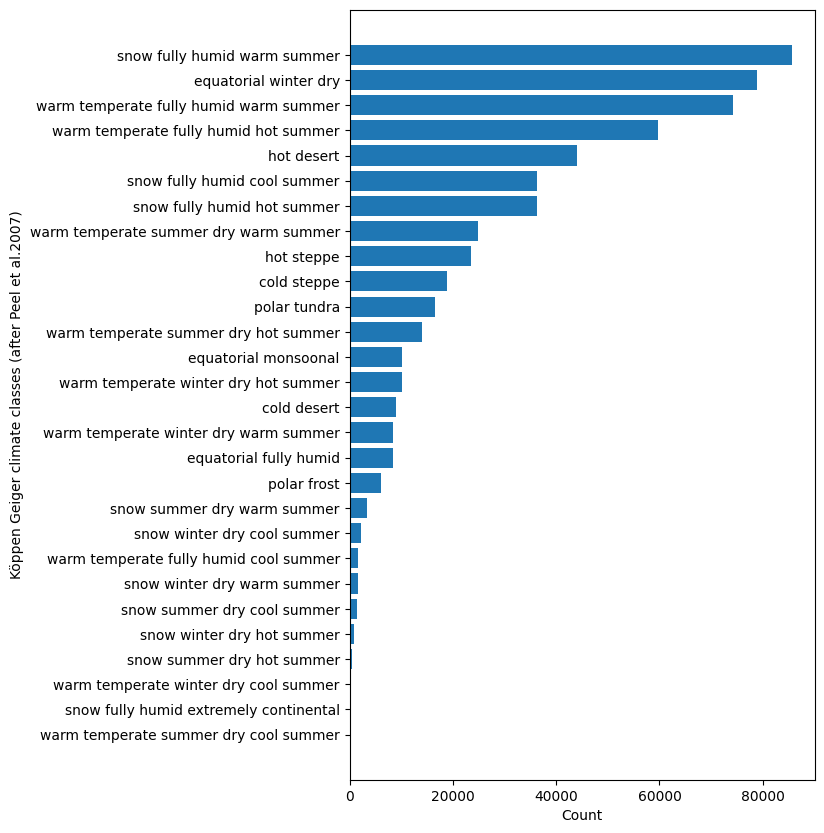

In [32]:
class_counts = df['clm_class'].value_counts()
# class_counts.sort_values(ascending=False).plot(kind='bar', figsize=(8, 6))

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(6, 10))
ax.barh(class_counts.index, class_counts.values)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_ylabel('Köppen Geiger climate classes (after Peel et al.2007)')
ax.set_xlabel('Count')

plt.show()
